<a href="https://colab.research.google.com/github/vaidehi2002vd/Notebooks/blob/main/Forced_PhotometryGRZY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install photutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install reproject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [163]:
import astropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from photutils.segmentation import detect_sources
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.segmentation import SourceFinder, SourceCatalog
from photutils.segmentation import deblend_sources
from astropy.wcs import WCS, wcs
from reproject import reproject_interp
from scipy import ndimage, datasets
from photutils.segmentation import make_2dgaussian_kernel
from astropy.convolution import convolve
from photutils.background import SExtractorBackground, MeanBackground
from astropy import units as u
from astropy import table
from astropy.table import QTable as Table
from photutils.aperture import BoundingBox, Aperture, PixelAperture, ApertureMask, EllipticalAperture, SkyEllipticalAperture

### **Photometry on Z Band**

**Storing the locations of required files**

In [ ]:
HSC_G_name    = '2-cutout-HSC-G-9075-pdr3_wide.fits'
HSC_R_name    = '3-cutout-HSC-R-9075-pdr3_wide.fits'
HSC_I_name    = '4-cutout-HSC-I-9075-pdr3_wide.fits'
HSC_Z_name    = '5-cutout-HSC-Z-9075-pdr3_wide.fits'
HSC_Y_name    = '6-cutout-HSC-Y-9075-pdr3_wide.fits'

HST_F110_name = 'ibjj05010_drz.fits'
HST_F160_name = 'ibjj05030_drz.fits'

Checking the extensions in each file

In [ ]:
fits.info(HSC_Z_name)

Filename: 5-cutout-HSC-Z-9075-pdr3_wide.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1                1 ImageHDU        31   (5955, 5953)   float32   
  2                1 ImageHDU        48   (5955, 5953)   int32   
  3                1 ImageHDU        31   (5955, 5953)   float32   


Opening Z file

In [ ]:
open_HSC_Z = fits.open(HSC_Z_name)
img_HSC_Z  = open_HSC_Z[1]
data_HSC_Z = img_HSC_Z.data.astype('float32')

Plotting the image

In [ ]:
plt.imshow(data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

Viewing the header

In [ ]:
header_Z_band = WCS(img_HSC_Z.header)
header_Z_band

Subtracting an estimate of the background using SEXtractor

In [ ]:
sigma_clip = SigmaClip(sigma=3.0)
bkg = MeanBackground(sigma_clip)
bkg_value = bkg.calc_background(data_HSC_Z)
filt_data_HSC_Z = data_HSC_Z - bkg_value

Plotting both filtered and actual image

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
ax1.imshow(data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)
ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)
ax2.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

Using ds9, find too bright sources and mask them

In [157]:
mask = np.zeros(shape = filt_data_HSC_Z.shape, dtype = bool)
mask[157:627, 5517:5907].fill(True)
mask[2829:3128, 4929:5182].fill(True)
mask[4772:4972, 3126:3361].fill(True)
mask[4892:5179, 1863:2125].fill(True)
mask[4678:5060, 3059:3409].fill(True)
mask[4527:4693, 3557:3732].fill(True)
mask[565:756, 3696:3849].fill(True)
mask[1319:1477, 3686:3769].fill(True)
mask[1578:1732, 2938:3140].fill(True)
mask[1619:1718, 1716:1842].fill(True)
mask[1319:1477, 3686:3769].fill(True)
mask[5234:5407, 0:127].fill(True)

In [245]:
kernel = make_2dgaussian_kernel(3.0, size=3)
convolved_data = convolve(filt_data_HSC_Z, kernel)
segment_map = detect_sources(convolved_data, threshold=.25, npixels=10, mask=mask)

<ipython-input-246-5dd26bcc69bb>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
<ipython-input-246-5dd26bcc69bb>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)


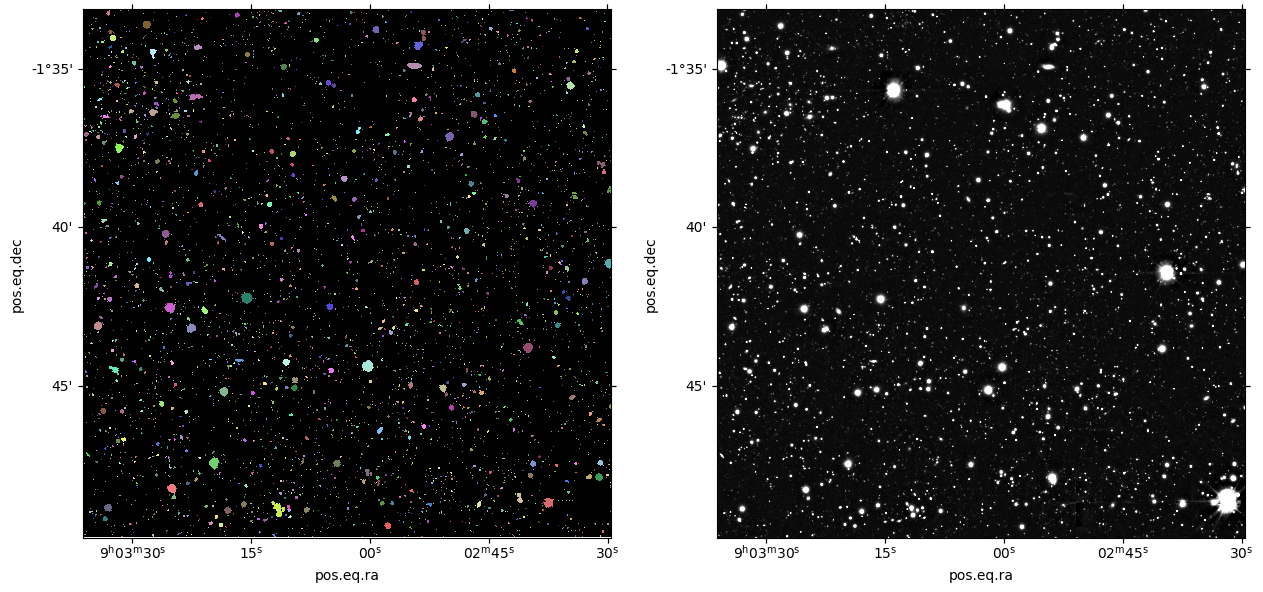

In [246]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
ax1.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)
ax2.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

In [159]:
segm_deblend = deblend_sources(convolved_data, segment_map, npixels=10, nlevels=35, contrast=0.001, progress_bar=False)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 15))

ax1 = plt.subplot(1, 3, 1, projection = header_Z_band)
ax1.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 3, 2, projection = header_Z_band)
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
ax3 = plt.subplot(1, 3, 3, projection = header_Z_band)
ax3.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

In [160]:
cat = SourceCatalog(filt_data_HSC_Z, segm_deblend, convolved_data=convolved_data, localbkg_width=5, wcs=header_Z_band, mask=mask)
Z_sources = cat.to_table()

In [171]:
a = Z_sources['semimajor_sigma'].value*.167999999999904*u.arcsec
b = Z_sources['semiminor_sigma'].value*.167999999999904*u.arcsec

apertures = []
for i in range(len(Z_sources)):
  apertures.append(SkyEllipticalAperture(Z_sources['sky_centroid'][i], a[i], b[i], Z_sources['orientation'][i]))

In [161]:
open_HSC_G = fits.open(HSC_G_name)
img_HSC_G  = open_HSC_G[1]
data_HSC_G = img_HSC_G.data.astype('float32')
sigma_clip = SigmaClip(sigma=3.0)
bkg = MeanBackground(sigma_clip)
bkg_value = bkg.calc_background(data_HSC_G)
filt_data_HSC_G = data_HSC_G - bkg_value

open_HSC_Y = fits.open(HSC_Y_name)
img_HSC_Y  = open_HSC_Y[1]
data_HSC_Y = img_HSC_Y.data.astype('float32')
sigma_clip = SigmaClip(sigma=3.0)
bkg = MeanBackground(sigma_clip)
bkg_value = bkg.calc_background(data_HSC_Y)
filt_data_HSC_Y = data_HSC_Y - bkg_value

In [234]:
from photutils.aperture.photometry import aperture_photometry
Flux_G = []
Flux_Y = []
for i in range(len(Z_sources)):
  phot_G = aperture_photometry(filt_data_HSC_G, apertures[i], wcs=header_Z_band)
  Flux_G.append(phot_G['aperture_sum'].value)
  # phot_Y = aperture_photometry(filt_data_HSC_Y, apertures[i], wcs=header_Z_band)
  # for i in range(len(phot_Y)):
  #     Flux_Y.append(phot_Y['aperture_sum'].value)

# for i in range(len(Z_sources)):
#     phot_Y = aperture_photometry(filt_data_HSC_Y, apertures[i], wcs=header_Z_band)
#     for i in range(len(phot_Y)):
#       Flux_Y.append(phot_Y['aperture_sum'])


In [218]:
Flux_G = []
for i in range(2):
  phot_G = aperture_photometry(filt_data_HSC_G, apertures[i], wcs=header_Z_band)
  Flux_G.append(phot_G['aperture_sum'].value)


[3.44384438815753]
[1.3286207216045662]


In [227]:
Source_Catalog = pd.DataFrame()
Source_Catalog['x_centroid'] = Z_sources['xcentroid']
Source_Catalog['y_centroid'] = Z_sources['ycentroid']
Source_Catalog['RA']  = Z_sources['sky_centroid'].ra.value
Source_Catalog['DEC'] = Z_sources['sky_centroid'].dec.value
Flux_G_band = []
for i in Flux_G:
  Flux_G_band.append(i.value)
Source_Catalog['Flux_Z'] = Z_sources['kron_flux']
Source_Catalog['Flux_Y'] = Flux_Y

In [233]:
Flux_G[1].value

array([1.32862072])

<ipython-input-239-c90c2d6d2f4d>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
<ipython-input-239-c90c2d6d2f4d>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)


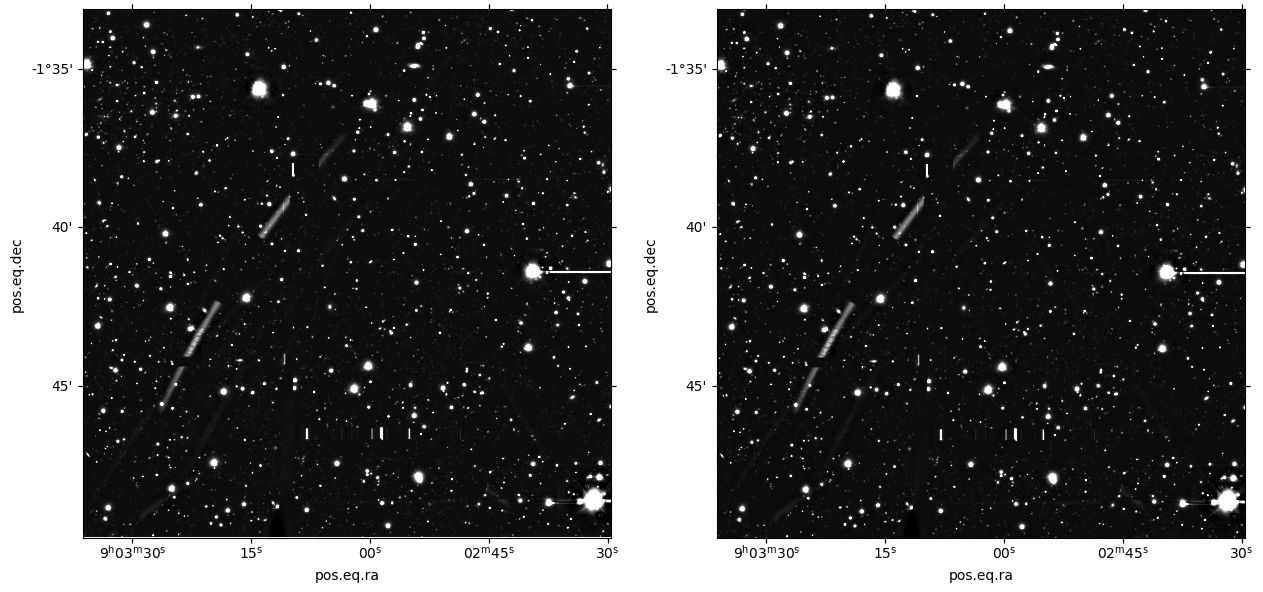

In [239]:
open_HSC_R = fits.open(HSC_R_name)
img_HSC_R  = open_HSC_R[1]
data_HSC_R = img_HSC_R.data.astype('float32')
sigma_clip = SigmaClip(sigma=3.0)
bkg = MeanBackground(sigma_clip)
bkg_value = bkg.calc_background(data_HSC_R)
filt_data_HSC_R = data_HSC_R - bkg_value

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
ax1.imshow(data_HSC_R, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)
ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)
ax2.imshow(filt_data_HSC_R, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

In [247]:
mask_R = np.zeros(shape = filt_data_HSC_Z.shape, dtype = bool)
mask_R[157:627, 5517:5907].fill(True)
mask_R[2829:3128, 4929:5182].fill(True)
mask_R[4772:4972, 3126:3361].fill(True)
mask_R[4892:5179, 1863:2125].fill(True)
mask_R[4678:5060, 3059:3409].fill(True)
mask_R[4527:4693, 3557:3732].fill(True)
mask_R[565:756, 3696:3849].fill(True)
mask_R[1319:1477, 3686:3769].fill(True)
mask_R[1578:1732, 2938:3140].fill(True)
mask_R[1619:1718, 1716:1842].fill(True)
mask_R[1319:1477, 3686:3769].fill(True)
mask_R[5234:5407, 0:127].fill(True)
mask_R[4074:4362, 2612:2746].fill(True)
mask_R[4158:4484, 2620:2950].fill(True)
mask_R[3432:3738, 1927:2357].fill(True)
mask_R[3421:3551, 1959:2221].fill(True)
mask_R[3295:3517, 1887:2201].fill(True)
mask_R[1881:2333, 1001:1453].fill(True)
mask_R[2173:2353, 1176:1434].fill(True)
mask_R[2201:2607, 1180:1572].fill(True)
mask_R[3539:3981, 2056:2440].fill(True)
mask_R[2456:2630, 1332:1604].fill(True)
mask_R[2540:2708, 1394:1622].fill(True)
mask_R[1692:2008, 924:1238].fill(True)
mask_R[1025:1859, 842:1160].fill(True)
mask_R[1302:1716, 769:1063].fill(True)

In [248]:
kernel = make_2dgaussian_kernel(3.0, size=3)
convolved_data = convolve(filt_data_HSC_R, kernel)
segment_map = detect_sources(convolved_data, threshold=.25, npixels=10, mask=mask_R)

In [260]:
Flux_R = []
for i in range(len(Z_sources)):
  phot_R = aperture_photometry(filt_data_HSC_R, apertures[i], wcs=header_Z_band)
  Flux_R.append(phot_R['aperture_sum'].value)

[array([3.99575139]),
 array([0.31126519]),
 array([2.21742901]),
 array([10.98811043]),
 array([-0.11330974]),
 array([6.80699206]),
 array([0.08281444]),
 array([33.54459174]),
 array([0.88945527]),
 array([55.81922966]),
 array([0.75582971]),
 array([2.72329019]),
 array([3.13931202]),
 array([0.190561]),
 array([-0.12938899]),
 array([0.20358784]),
 array([0.00693391]),
 array([0.10615315]),
 array([36.51743825]),
 array([4.21740522]),
 array([54.84674994]),
 array([0.62882116]),
 array([0.75855026]),
 array([0.78203743]),
 array([2.4643442]),
 array([10.40546334]),
 array([0.4945687]),
 array([0.06817546]),
 array([0.51839047]),
 array([0.22816965]),
 array([53.84206817]),
 array([0.63008732]),
 array([10.72492217]),
 array([7.7049036]),
 array([-0.05647915]),
 array([2.54591946]),
 array([142.03573112]),
 array([0.52296761]),
 array([0.39738557]),
 array([4.87789129]),
 array([17.35300127]),
 array([1.95439847]),
 array([0.30010706]),
 array([31.63270217]),
 array([1.99843897]),


In [251]:
cat_R = SourceCatalog(filt_data_HSC_R, segment_map, convolved_data=convolved_data, localbkg_width=5, wcs=header_Z_band, mask=mask_R)
R_sources = cat_R.to_table()

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,314.1917239677496,1.7288301993931303,"135.88644107804268,-1.8295971344740949",309,319,0,5,50.0,2.536455756500648,1.3361623822187114,-0.14554486887398094,0.8499996575101646,0.029477229152833767,1.0226842964040392,0.14138380643256968,16.800724150474636,nan,22.253256134546074,nan
2,440.23009920169136,4.009281175492103,"135.88055686391618,-1.8294923995032468",431,450,0,12,208.0,3.8630652836903896,2.83394347690742,-0.605056621252492,0.679581857864303,0.15378713711651365,3.2352599064961294,-0.0011245171681265008,222.19806129482248,nan,247.57411015877008,nan
3,1749.8362418086492,2.097839146493958,"135.81941653337188,-1.8295978723342121",1745,1753,0,4,19.0,2.235619698989705,1.0275374689437058,17.496230470018496,0.8881152271647514,0.08438193505097713,0.5371539861469397,0.019079121896731006,5.152498785621885,nan,16.66897911092451,nan
4,3145.8142408559506,1.6929272642987991,"135.75424269564343,-1.829631828483264",3137,3155,0,6,96.0,3.583296203838316,1.5348084141220257,0.07191540458686471,0.9036256701092211,0.08241277957874302,3.911172479638634,0.0039364395050429934,86.75817450277115,nan,103.03409610014879,nan
5,3813.4075825057225,4.65078096753809,"135.7230744589759,-1.82950017148862",3803,3827,0,13,237.0,5.169814930849153,2.8148707324053417,-16.580173517759317,0.8387725821222209,0.07128185243749216,1.7135630419983823,0.0052099653945009376,162.57566279757452,nan,192.12024882371676,nan
6,4741.496758943197,2.0861624701227974,"135.6797440673373,-1.8296277977179747",4738,4747,0,4,29.0,2.6242222736353553,1.0491087256464386,-6.184993383365782,0.9166115979219571,-0.035927211890496635,0.3658070657155138,0.1399600412943739,5.102574453903777,nan,3.917038311969301,nan
7,4856.286575671134,2.599747656575785,"135.67438475560326,-1.8296047428156843",4854,4859,1,5,23.0,1.6501400085523958,1.1462603388661778,-1.427500463430699,0.7193533949412663,0.06047346746054244,0.43419432198134017,0.055082295784086466,6.162160846272308,nan,10.390558643455554,nan
8,1930.1436844576517,6.001812120863867,"135.81099855050473,-1.8294177796636077",1926,1934,2,11,66.0,2.299028611978243,1.8676685710675263,43.8846169165475,0.58313827681053,0.0828374259858666,1.16375023953014,-0.004775234380298678,32.8549382776515,nan,45.75521997705508,nan


In [ ]:
|from photutils.aperture.ellipse import EllipticalAperture
#check with ds9 and notes coordinates
index = [370, 6037, 9336, 9533]
x_too_big = []
y_too_big = []
bbox_xmin = []
bbox_ymin = []
bbox_xmax = []
bbox_ymax = []
# theta     = []
# semimajor = []
# semiminor = []
for i in index:
  x_too_big.append(Z_sources_blend['xcentroid'][i])
  y_too_big.append(Z_sources_blend['ycentroid'][i])
  # semimajor.append(Z_sources_blend['semimajor_sigma'][i].to_value())
  # semiminor.append(Z_sources_blend['semiminor_sigma'][i].to_value())
  # theta.append(Z_sources_blend['orientation'][i])
  bbox_xmin.append(int(Z_sources_blend['bbox_xmin'][i]))
  bbox_xmax.append(int(Z_sources_blend['bbox_xmax'][i]))
  bbox_ymin.append(int(Z_sources_blend['bbox_ymin'][i]))
  bbox_ymax.append(int(Z_sources_blend['bbox_ymax'][i]))


positions = np.transpose((x_too_big, y_too_big))

bbox0 = BoundingBox(bbox_xmin[0], bbox_xmax[0], bbox_ymin[0], bbox_ymax[0])
bbox1 = BoundingBox(bbox_xmin[1], bbox_xmax[1], bbox_ymin[1], bbox_ymax[1])
bbox2 = BoundingBox(bbox_xmin[2], bbox_xmax[2], bbox_ymin[2], bbox_ymax[2])
bbox3 = BoundingBox(bbox_xmin[3], bbox_xmax[3], bbox_ymin[3], bbox_ymax[3])
# aperture0 = EllipticalAperture(positions[0], a=semimajor[0], b=semiminor[0], theta=theta[0])
# aperture1 = EllipticalAperture(positions[1], a=semimajor[1], b=semiminor[1], theta=theta[1])
# aperture2 = EllipticalAperture(positions[2], a=semimajor[2], b=semiminor[2], theta=theta[2])
# aperture3 = EllipticalAperture(positions[3], a=semimajor[3], b=semiminor[3], theta=theta[3])
# mask0 = aperture0.to_mask()
# mask1 = aperture1.to_mask()
# mask2 = aperture2.to_mask()
# mask3 = aperture3.to_mask()

mask = np.zeros(shape = filt_data_HSC_Z.shape, dtype = bool)
mask[157:627, 5517:5907].fill(True)
mask[2829:3128, 4929:5182].fill(True)
mask[4772:4972, 3126:3361].fill(True)
mask[4892:5179, 1863:2125].fill(True)


In [ ]:
kernel = make_2dgaussian_kernel(3.0, size=3)
convolved_data = convolve(filt_data_HSC_Z, kernel)
segment_map = detect_sources(convolved_data, threshold=.2, npixels=10, mask=mask)

<ipython-input-211-5dd26bcc69bb>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
<ipython-input-211-5dd26bcc69bb>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)


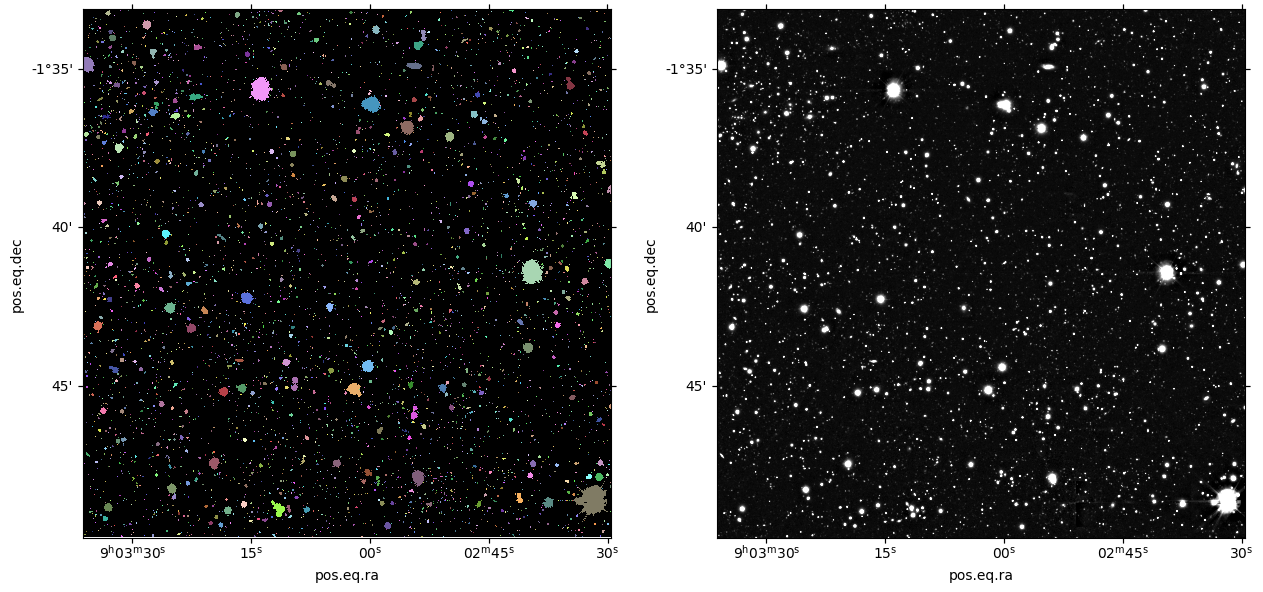

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
ax1.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)
ax2.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

In [ ]:
segm_deblend = deblend_sources(convolved_data, segment_map, npixels=10, nlevels=35, contrast=0.001, progress_bar=False)

<ipython-input-27-9014d985f7ec>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
<ipython-input-27-9014d985f7ec>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)


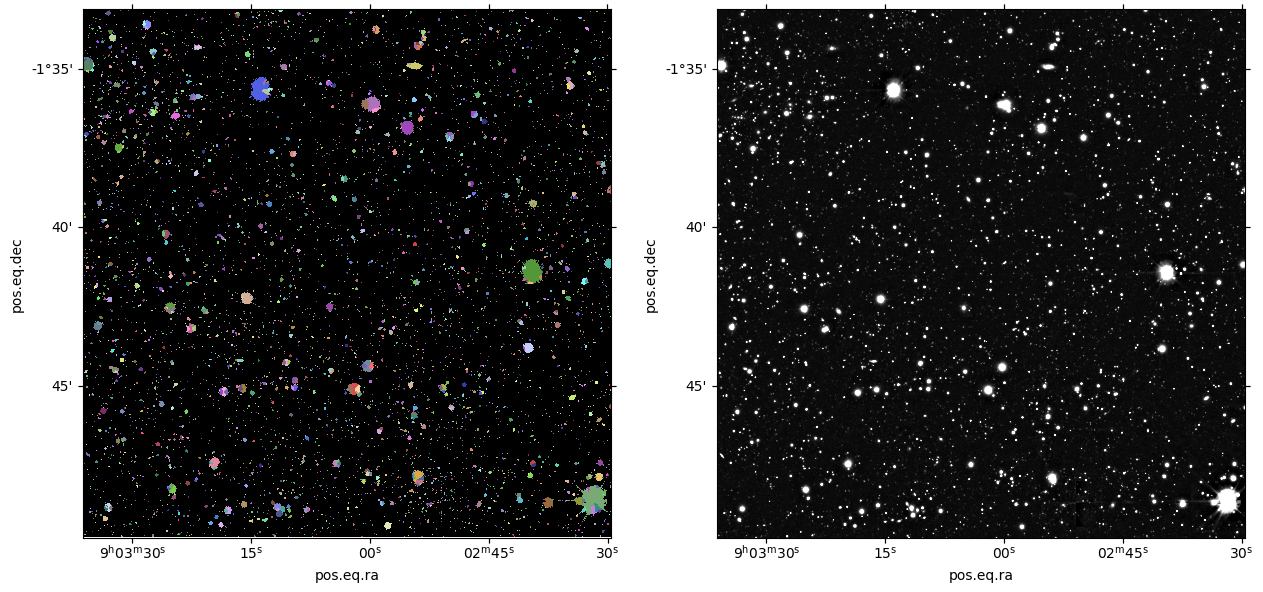

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
ax1.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)
ax2.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

In [ ]:
cat = SourceCatalog(filt_data_HSC_Z, segm_deblend, convolved_data=convolved_data, localbkg_width=5, wcs=header_Z_band)
Z_sources_FP = cat.to_table()

In [ ]:
Z_sources_FP

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,313.9872523283124,1.1647494375463094,"135.88645063312376,-1.829623453151341",310,318,0,4,32.0,1.7109016116618345,1.0599957519407583,7.136955839927177,0.7849541229859056,0.0015338166803121611,3.3230508594959973,0.0362530917674303,24.891172665953636,nan,28.39141202138449,nan
2,375.28912402362306,2.913326921520435,"135.8835886913066,-1.829542678049421",371,381,0,6,49.0,2.2197506818461803,1.587144441799756,6.819708867100792,0.6991139917237456,0.04107242551011343,1.0858753743426253,0.05697049472170572,16.586780318136636,nan,17.83679365663831,nan
3,402.8495534531744,2.462832961251788,"135.88230202320892,-1.8295640654520509",400,406,0,6,30.0,1.656678637564794,1.3927827081023099,-48.110607266486355,0.5414890015352184,-0.25028690240847373,0.7648739115191767,0.03304589829909113,8.452429967502562,nan,13.665719482789417,nan
4,1365.2244685430048,2.053898578546066,"135.83737265734683,-1.8295953574058075",1363,1368,0,5,31.0,1.5374828220254122,1.3896133184997221,-55.1398574076828,0.4279051650705793,-0.06068165195465554,0.9516961140063358,0.07549767070740927,11.504489687041495,nan,8.512151733533155,nan
5,1749.4035622346614,2.066570848189829,"135.81943673409984,-1.8295993263701933",1742,1755,0,6,60.0,3.062293403360709,1.4996365199411936,-1.705095919914336,0.8718852301048805,-0.06888702820604628,0.940099809955899,-0.042672966312710586,24.555388752879598,nan,51.448225016701215,nan
6,1930.2345410310436,6.18959729100624,"135.81099430610647,-1.8294090180816382",1921,1942,0,16,216.0,2.3978569655951243,2.315532709988412,4.184488598852961,0.2597809531012345,-0.1335161931007325,29.769168733885962,-0.0421446555168212,506.01852821733837,nan,497.5501762382524,nan
7,2280.5783033827,1.494044910221322,"135.79463798342198,-1.8296320522828553",2277,2284,0,3,23.0,1.8692098928107372,0.8946616478156704,-12.792218152917219,0.8780161979606398,-0.14347536640852923,0.8473685405901051,0.016161081964673946,7.885654023465759,nan,10.561229213750664,nan
8,2315.1852528329537,5.975247131406795,"135.79302223609568,-1.8294233251380685",2310,2320,0,12,102.0,2.1785798009436896,1.90732288754827,-83.31302985240056,0.48323785141413905,0.01916327585182074,5.945759215407957,-0.018817820602049264,111.71050899892936,nan,117.9395771738074,nan
